# Chapter 5: Monte Carlo 

## Black-Jack Example

An episodic finite MDP

In [1]:
from __future__ import division
import numpy as np

In [2]:
# globals
card_values = {'01':{'low':1, 'high':11}, '02':2, '03':3, '04':4, '05':5, '06':6, '07':7, '08':8, '09':9, '10':10, '11':10, '12':10, '13':10 }
states = range(4, 30)
actions = np.array(['stick', 'hit'])

# dealer policy
dealer_policy = {s:[0.0, 1.0] for s in range(4,17)}
for s in range(17,31): dealer_policy[s] = [1.0, 0.0]


In [3]:
def deal():
    # deal 1 card
    return np.random.choice(np.array(card_values.keys()), p=[1/12]*12)

In [4]:
def result(player_trace, dealer_trace):
    player_state = player_trace[-1][0]    
    dealer_state = dealer_trace[-1][0]
    if player_state > 21 : return -1
    elif dealer_state > 21: return 1
    elif player_state < dealer_state: return -1
    elif player_state > dealer_state: return 1
    elif player_state == dealer_state:
        if player_state == 21 and len(player_trace) == 1:
            if dealer_state == 21 and len(dealer_trace) == 1: return 0
            else: return 1
        else: return -1

In [5]:
def evaluate(hand):
    v = 0
    for card in sorted(hand, reverse=True):
        card_value = card_values[card]
        if card == '01':
            v += card_value['high'] if (v + card_value['high'])<= 21 else card_value['low']
        else:
            v += card_value
    return v        

In [6]:
def play(hand, policy):
    # determine state 
    # (the state is the hand but the only part of the hand that matters to the policy is just its value)
    s = evaluate(hand)
    
    # sample an action according to the distribution given by the policy 
    a = np.random.choice(actions, p=policy[s])

    trace = [(s, a)]
    # repeat while the policy returns 'hit'
    while a == 'hit':
        hand.append(deal())
        s = evaluate(hand)
        a = np.random.choice(actions, p=policy[s])
        trace.append((s,a))
    
    return trace

In [7]:
def episode(player_policy):

    dealer_hand = [deal(), deal()] 
    player_hand = [deal(), deal()]

    player_trace = play(player_hand, player_policy)    
    dealer_trace = play(dealer_hand, dealer_policy)
    
    return {'trace': player_trace, 'result': result(player_trace, dealer_trace)}

In [8]:
def simulation(N, player_policy):
    return [episode(player_policy) for _ in range(N)]

## Propose a Policy, Generate episodes, Evaluate policy with monte carlo

In [9]:
# design a player policy
player_policy = {}
for s in range(4,12): player_policy[s] = [0., 1.]
for s in range(12,15): player_policy[s] = [0.0, 1.0]
for s in range(15,17): player_policy[s] = [0.5, 0.5]
for s in range(17,19): player_policy[s] = [0.8, 0.2]
for s in range(19,31): player_policy[s] = [1., 0.]

In [10]:
# generate data simulating episodes according to the policy
N = 10000
episodes = simulation(N, player_policy)
print episodes[0]

{'result': -1, 'trace': [(6, 'hit'), (17, 'hit'), (15, 'stand')]}


In [11]:
def state_values(states, episodes):
    values = []
    for s in states:
        data = []
        for e in episodes:
            found = False
            for s_a in e['trace']:
                if s_a[0] == s:
                    found = True
                    break # first-visit
            if found:
                data.append(e)
                
        values.append(sum([e['result'] for e in data])/(len(data) + 1e-10))
        
    return values

In [12]:
# evaluate the policy
states = range(4, 22)
values = state_values(states, episodes)

st_vals = zip(states, values)
for s, v in st_vals:
    print 'state: %d     value: %0.4f' % (s, v)

state: 4     value: -0.2424
state: 5     value: -0.2714
state: 6     value: -0.4641
state: 7     value: -0.2817
state: 8     value: -0.2952
state: 9     value: -0.1392
state: 10     value: -0.0390
state: 11     value: -0.0105
state: 12     value: -0.3252
state: 13     value: -0.4043
state: 14     value: -0.4112
state: 15     value: -0.4701
state: 16     value: -0.4497
state: 17     value: -0.4420
state: 18     value: -0.2150
state: 19     value: 0.1320
state: 20     value: 0.4504
state: 21     value: 0.8356


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

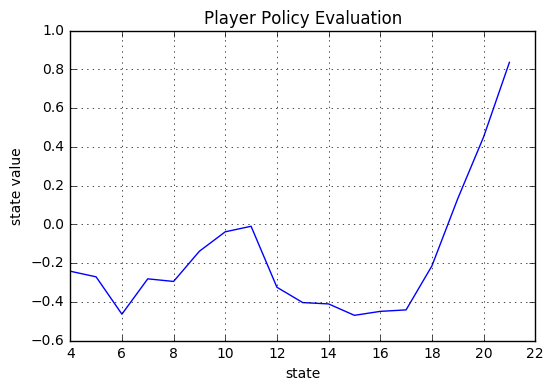

In [14]:
sva = np.array(st_vals)
plt.plot(states, values)
plt.ylabel('state value')
plt.xlabel('state')
plt.grid(True)
plt.title('Player Policy Evaluation')